In [1]:
import pandas as pd
import os
import json
import re
import numpy as np
import evaluate
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#!pip install seaborn

In [3]:
#!pip install sacrebleu

In [4]:
#!pip install evaluate

In [5]:
MODEL_NAME = 'intfloat/multilingual-e5-large'
model = SentenceTransformer(MODEL_NAME)

In [6]:
#src_lang = 'English'
trg_lang = 'Faroese'

In [7]:
TRANSLATION_FILE = f'data/{trg_lang}_Latn.devtest'
df_translation_data = pd.read_csv(TRANSLATION_FILE, sep='delimiter', 
                                  header=None, engine='python')
ref_translation = list(df_translation_data[0])

In [8]:
import pandas as pd
import os
import re
import json

# Create an empty DataFrame to store your JSON data
df = pd.DataFrame()

# Specify the folder where your JSON files are located
folder_path = 'results'

# Use a regular expression to match the integer in the filename
pattern = r'(\d+)'

# Use a loop to iterate through each JSON file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        if 'random' in filename:
            selection = 'random'
        else:
            selection = 'selected'
            
        # Extract the integer from the filename using regex
        match = re.search(pattern, filename)
        if match:
            file_number = int(match.group(1))
        else:
            file_number = None
            
        file_path = os.path.join(folder_path, filename)
        
        # Read the JSON file into a list of dictionaries
        with open(file_path, 'r') as file:
            data_list = json.load(file)
        
        # Add a new 'Selection_mode' and 'Number_of_examples' key to each dictionary in the list
        for data in data_list:
            data['Selection_mode'] = selection
            data['Number_of_examples'] = file_number  # Add the extracted number
        
        # Convert list of dictionaries to DataFrame and concatenate with the existing DataFrame
        temp_df = pd.DataFrame(data_list)
        df = pd.concat([df, temp_df], ignore_index=True)

# Display the DataFrame
df


,English,Faroese,confidence,Selection_mode,Number_of_examples,said he according to a transcript of the news conference
0,We now have 4-month-old mice that are non-diab...,"Vit hava nú fýra mánaðar gamlar mús, sum ikki ...",0.95,selected,1,NaN
1,"Dr. Ehud Ur, professor of medicine at Dalhousi...","Dr. Ehud Ur, professari í medisini á Dalhousie...",0.95,selected,1,NaN
2,"Like some other experts, he is skeptical about...","Summir aðrir serfrøðingar, er hann skeptiskur ...",0.95,selected,1,NaN
3,"On Monday, Sara Danius, permanent secretary of...","Mánadagin kunngjørdi Sara Danius, støðugur skr...",0.9,selected,1,NaN
4,"Danius said, ""Right now we are doing nothing. ...","Danius segði, ""Júst nú gera vit einki. Eg havi...",0.95,selected,1,NaN
...,...,...,...,...,...,...
8091,"As the areas are sparsely populated, and light...",Tí at økini eru tætt við fólki og ljósóreinsan...,NaN,random,8,NaN
8092,Japanese work culture is more hierarchical and...,Japanska arbeiðsmenningin er meira hierarkisk ...,NaN,random,8,NaN
8093,"Suits are standard business attire, and cowork...","Jakksæt eru vanligur handilsklæðnaður, og star...",NaN,random,8,NaN
8094,"Workplace harmony is crucial, emphasizing grou...","Samstarv á arbeiðsplássinum er avgerandi, við ...",NaN,random,8,NaN


In [9]:
N_examples = df['Number_of_examples'].unique()
N_examples = sorted(N_examples)
sel_mode = df['Selection_mode'].unique()

In [10]:
N_examples

[1, 4, 8, 12]

In [11]:
sacrebleu = evaluate.load("sacrebleu")
chrf = evaluate.load("chrf")

In [12]:
df_nexamples = df[df['Number_of_examples'] == n]

NameError: name 'n' is not defined

In [13]:
ref_translation

['“Nú hava vit 4 mánaðar gamlar mýs, sum ikki hava sukursjúku, sum fyrr høvdu sukursjúku,” legði hann afturat.',
 'Doktari Ehud Ur, professari í læknavísindi á Dalhousie fróðskaparsetri í Halifax, Nova Scotia og formaður fyri klinisku og vísindaligu deildina í kanadiska sukursjúku-felagsskapinum ávaraði um, at granskingin enn er tíðliga í tilgongdini.',
 'Eins og aðrir serfrøðingar, ivast hann í, um sukursjúka kann grøðast, og ger vart við, at hesi úrslitini ongan týdning hava fyri fólk, sum longu hava sukursjúku slag 1.',
 'Mánadagin kunngjørdi Sara Danius, verandi skrivari hjá Nobel nevndini fyri bókmentir á svenska háskúlanum, alment í einari útvarpssending í Sveriges Radio í Svøríki, at nevndin, sum ikki var før fyri at fáa beinleiðis samband við Bob Dylan, viðvíkjandi at hava vunnið 2016 nobelvirðislønina í bókmentum, var givin við at royna at fáa samband við hann.',
 'Danius segði, "Beint nú gera vit einki. Eg havi ringt og sent teldupost til hansara nærmastu samstarvsfólk og mót

In [ ]:
df_results = pd.DataFrame()

for n in N_examples:
    df_nexamples = df[df['Number_of_examples'] == n]
    for sel in sel_mode:
        df_selected = df_nexamples[df_nexamples['Selection_mode'] == sel]
        translation_ = list(df_selected[trg_lang])
        df_selected['Reference'] = ref_translation
        
        BLEU = []
        CHRF = []
        SIMILARITY = []
        
        for index, translation in enumerate(translation_):
            
            bleu_score = sacrebleu.compute(predictions=[translation], 
                            references= [ref_translation[index]], 
                            smooth_method = 'floor')
            chrf_score = chrf.compute(predictions=[translation], 
                            references= [ref_translation[index]])
            
            embedding_translation = model.encode(translation)
            embedding_reference = model.encode(ref_translation[index])
            sim_score = cos_sim(embedding_translation, embedding_reference)
            
            BLEU.append(bleu_score['score'])
            CHRF.append(chrf_score['score'])
            SIMILARITY.append(float(sim_score))
            
        df_selected['BLEU'] = BLEU
        df_selected['CHRF'] = CHRF
        df_selected['SEMANTIC SIMILARITY'] = SIMILARITY
        frames = [df_results, df_selected]
        df_results = pd.concat(frames)

C:\Users\barbaras\AppData\Local\Temp\ipykernel_19436\3253175486.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Reference'] = ref_translation
C:\Users\barbaras\AppData\Local\Temp\ipykernel_19436\3253175486.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['BLEU'] = BLEU
C:\Users\barbaras\AppData\Local\Temp\ipykernel_19436\3253175486.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [45]:
df_results.to_csv(f'results/scores_{trg_lang}.csv')

In [46]:
df_results = pd.read_csv(f'results/scores_{trg_lang}.csv')
N_examples = df_results['Number_of_examples'].unique()
N_examples = sorted(N_examples)

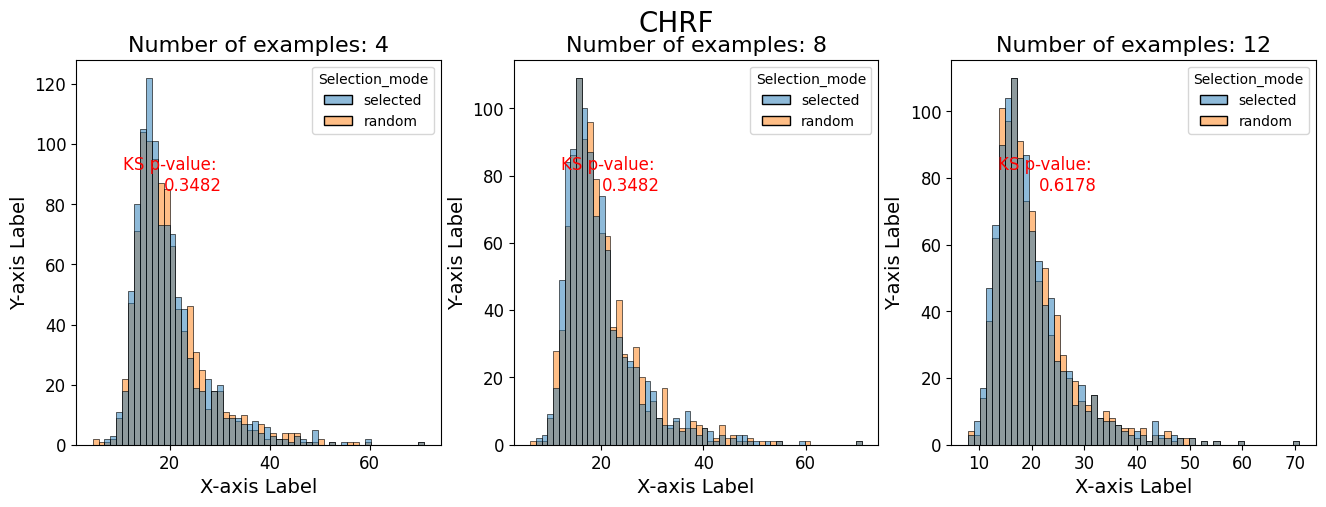

In [77]:
# Create a row of subplots for each value of N_examples
num_plots = len(N_examples)
fig, axes = plt.subplots(1, num_plots, figsize=(16, 5))

score = 'CHRF'
plt.suptitle(score, fontsize=20)

for i, n in enumerate(N_examples):
    df_nexamples = df_results[df_results['Number_of_examples'] == n]
    ax = axes[i]
    
    ax.set_title(f'Number of examples: {n}', fontsize=16)  # Increase title font size
    
    # Create histograms for 'random' and 'selected' modes in the same subplot
    sns.histplot(x=score, hue='Selection_mode', data=df_nexamples, 
                 ax=ax)
    
    # Perform the Kolmogorov-Smirnov test
    random = np.array(df_nexamples[df_nexamples['Selection_mode'] == 'random'][score])
    selected = np.array(df_nexamples[df_nexamples['Selection_mode'] == 'selected'][score])
    statistic, p_value = stats.kstest(random, selected)
    
    ax.text(
        0.4, 0.7, f'KS p-value: \n{p_value:.4f}',
        transform=ax.transAxes, fontsize=12, color='red',
        horizontalalignment='right', verticalalignment='center'
    )

    # Increase font size for axis labels and ticks
    ax.set_xlabel('X-axis Label', fontsize=14)
    ax.set_ylabel('Y-axis Label', fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=12)  # Increase tick font size

plt.savefig(f'results/figures/{score}_{trg_lang}.jpg')

<Axes: xlabel='confidence', ylabel='Count'>

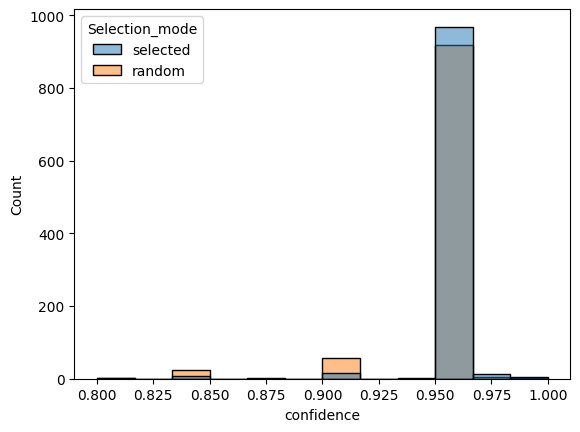

In [72]:
sns.histplot(x = 'confidence', hue = 'Selection_mode', data = df )


In [74]:
random = np.array(df_nexamples[df_nexamples['Selection_mode'] == 'random']['confidence'])
selected = np.array(df_nexamples[df_nexamples['Selection_mode'] == 'selected']['confidence'])
statistic, p_value = stats.kstest(random, selected)

In [75]:
p_value

0.04478944223303421